In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.3 MB/s eta 0:00:00


In [2]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 5.6 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import yfinance as yf

from arch import arch_model
from pmdarima.model_selection import train_test_split
from scipy.stats import chi2, jarque_bera
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima.model import ARIMA

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import pandas as pd
df = pd.read_csv("gdrive/My Drive/Colab Notebooks/Capstone/ForEx_Dataset.csv")

In [6]:
df = df[['Date', 'CAN']]

In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df_month = df.resample('MS').mean()
#df_month = df.resample('W').mean()
print('Count of The Monthly Data Frame : ',df_month.shape[0])
df_month.head()

Count of The Monthly Data Frame :  216


<ipython-input-7-875a06f81414>:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


,CAN
Date,
2006-01-01,38.242818
2006-02-01,38.510800
2006-03-01,38.351652
2006-04-01,39.211500
2006-05-01,40.787739


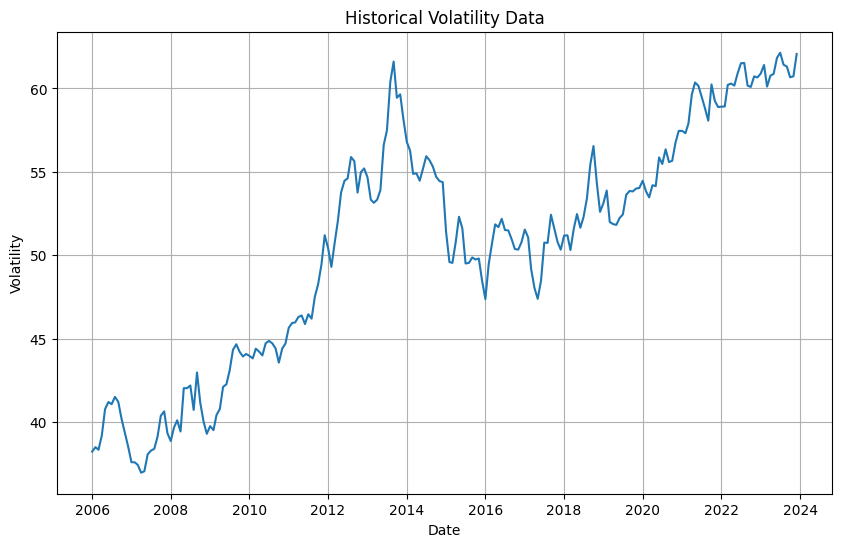

In [8]:
import matplotlib.pyplot as plt

# Plot the historical volatility data
plt.figure(figsize=(10, 6))
plt.plot(df_month.index, df_month["CAN"])
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Historical Volatility Data")
plt.grid(True)

plt.show()

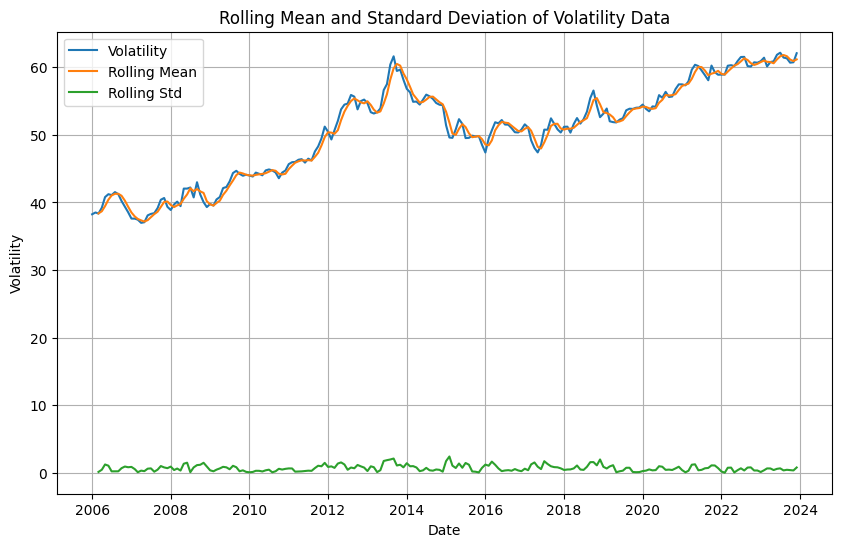

In [9]:
# Calculate the rolling mean and standard deviation
rolling_mean = df_month["CAN"].rolling(window=3).mean()
rolling_std = df_month["CAN"].rolling(window=3).std()

# Plot the rolling mean and standard deviation
plt.figure(figsize=(10, 6))
plt.plot(df_month.index, df_month["CAN"], label="Volatility")
plt.plot(rolling_mean.index, rolling_mean, label="Rolling Mean")
plt.plot(rolling_std.index, rolling_std, label="Rolling Std")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Rolling Mean and Standard Deviation of Volatility Data")
plt.legend()
plt.grid(True)

plt.show()

In [10]:
from statsmodels.tsa.stattools import adfuller
x=df_month['CAN']
result=adfuller(x)
print("ADF Stataics ",result[0])
print("p-value",result[1])
print("critical values",result[5])
if result[1]<=0.05:
    print("fail to reject null hypothese h1 , it mean data is stationary")
else:
    print("Reject the null hypotheise , it mean data is not stationary")

ADF Stataics  -1.245500229628585
p-value 0.6537230120846698
critical values 559.5268493155365
Reject the null hypotheise , it mean data is not stationary


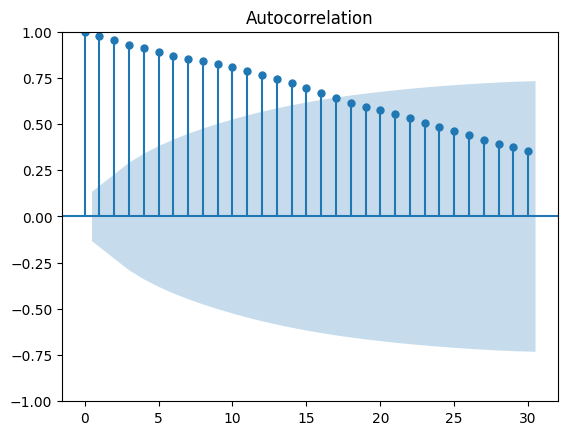

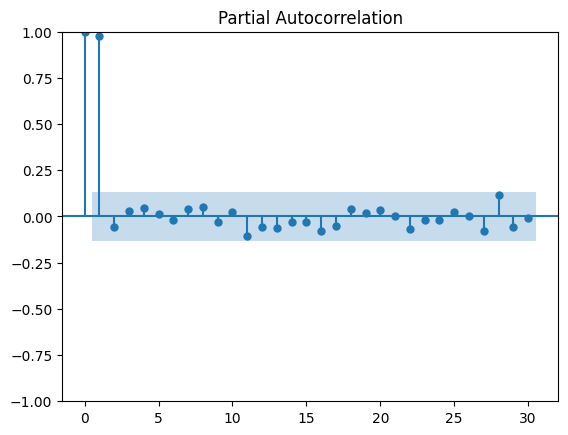

In [11]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import matplotlib.pyplot as plt

plot_acf(df_month['CAN'].iloc[1:],lags=30)
plot_pacf(df_month['CAN'].iloc[1:],lags=30)
plt.show()

In [12]:
df_month['CAN_1']=df_month['CAN']-df_month['CAN'].shift(1)

In [13]:
x=df_month['CAN_1'].dropna()
result=adfuller(x)
print("ADF Stataics ",result[0])
print("p-value",result[1])
print("critical values",result[5])
if result[1]<=0.05:
    print("fail to reject null hypothese h1 , it mean data is stationary")
else:
    print("Reject the null hypotheise , it mean data is not stationary")

ADF Stataics  -12.29400892267841
p-value 7.712336454624692e-23
critical values 558.6039726692059
fail to reject null hypothese h1 , it mean data is stationary


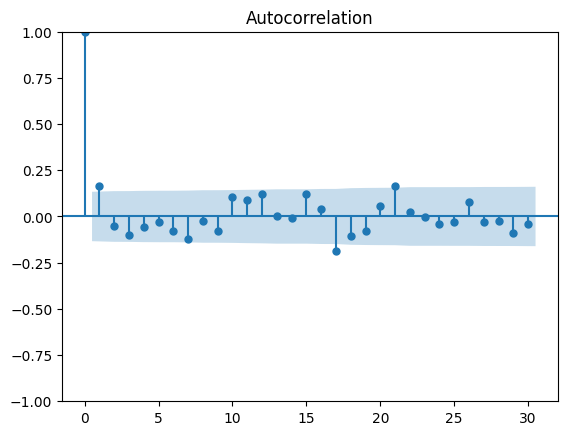

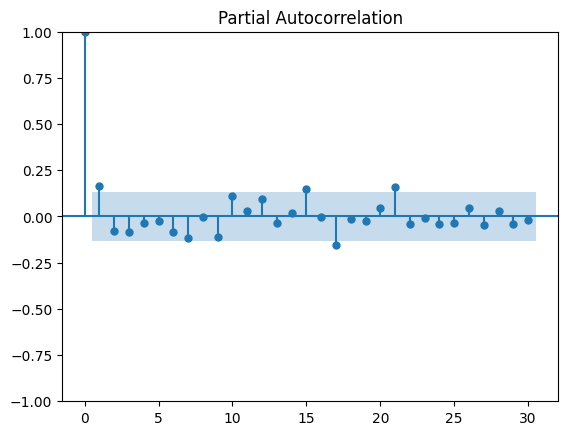

In [14]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import matplotlib.pyplot as plt

plot_acf(df_month['CAN_1'].iloc[1:],lags=30)
plot_pacf(df_month['CAN_1'].iloc[1:],lags=30)
plt.show()

In [15]:
import numpy as np
from arch import arch_model

In [16]:
returns = np.log(df_month["CAN"]).diff().dropna()

In [17]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    model = arch_model(returns, vol='Garch', p=1, q=1)
    results = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2119712712.6144967
Iteration:      2,   Func. Count:     17,   Neg. LLF: -361.985167504134
Iteration:      3,   Func. Count:     26,   Neg. LLF: -542.4080952152995
Iteration:      4,   Func. Count:     33,   Neg. LLF: -542.2238009235427
Iteration:      5,   Func. Count:     40,   Neg. LLF: -548.004467979782
Iteration:      6,   Func. Count:     46,   Neg. LLF: -548.021669284363
Iteration:      7,   Func. Count:     52,   Neg. LLF: -548.0360436728442
Iteration:      8,   Func. Count:     56,   Neg. LLF: -548.0360436728731
Optimization terminated successfully    (Exit mode 0)
            Current function value: -548.0360436728442
            Iterations: 8
            Function evaluations: 56
            Gradient evaluations: 8


In [18]:
volatility = results.conditional_volatility

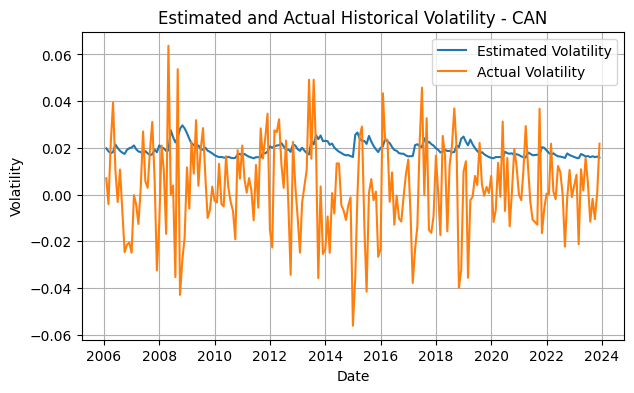

In [25]:
# Plot the estimated and actual volatility
plt.figure(figsize=(7, 4))
plt.plot(volatility.index, volatility, label="Estimated Volatility")
plt.plot(returns.index, returns, label="Actual Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Estimated and Actual Historical Volatility - CAN")
plt.legend()
plt.grid(True)

plt.show()

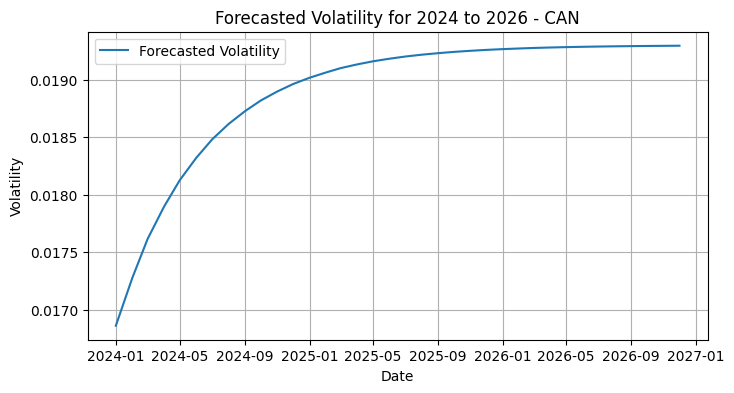

In [21]:
forecast_horizon = 36
forecasts = results.forecast(horizon=forecast_horizon)

# Extract the forecasted conditional volatility
forecasted_volatility = np.sqrt(forecasts.variance.dropna().iloc[-1])

# Plot the forecasted volatility for 2024 and 2025
forecast_dates = pd.date_range(start='2024-01-01', end='2026-12-01', freq='MS')

plt.figure(figsize=(8, 4))
#plt.plot(volatility.index, volatility, label="Estimated Volatility")

# Check if forecasted volatility is available for the forecast_dates
#if not forecasted_volatility.empty:
plt.plot(forecast_dates, forecasted_volatility, label="Forecasted Volatility")

plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Forecasted Volatility for 2024 to 2026 - CAN")
plt.legend()
plt.grid(True)

#plt.xticks(forecast_dates, [date.strftime('%B') for date in forecast_dates])

plt.show()

In [26]:
mae = np.mean(np.abs(volatility - returns))
print("Mean Absolute Error (MAE):", mae)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((volatility - returns) ** 2))
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 0.020998218554580107
Root Mean Squared Error (RMSE): 0.025984831832791974
